In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv, json
import pandas as pd
import scipy.optimize as sp
import itertools

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from scipy.ndimage import gaussian_filter1d
import scipy.signal as sg

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/bdry_log_aux_funcs.py

In [3]:
#run_dir = "fresh_rerun/"
run_dir = "mag_scaling/"

log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = log_file['ts'].tolist()
#log_file['L'].tolist()
selected_files = log_file
selected_files

ts_list = selected_files['ts'].tolist()
n_runs_list = selected_files['n_runs'].tolist()
L_list = selected_files['L'].tolist()

selected_files

,L,steps,a,b,w,n_runs,ts
0,10,99,0.1,0.105,5.7,1600,965294311057.01.0
1,10,99,0.1,0.105,5.5,1600,965353411055.01.0
2,10,99,0.1,0.105,5.9,1600,965408421059.01.0
3,10,99,0.1,0.105,6.1,1600,965467921061.01.0
4,10,99,0.1,0.105,6.3,1600,965561691063.01.0
5,10,99,0.1,0.105,6.5,1600,965615911065.01.0
6,10,99,0.1,0.105,6.7,1600,965669401067.01.0
7,10,99,0.1,0.105,6.9,1600,965723531069.01.0
8,10,99,0.1,0.105,7.1,1600,965777211071.01.0
9,10,99,0.1,0.105,7.3,1600,965832881073.01.0


In [52]:
def get_active_clust_sizes(reverse_dict, active_clust, track_decimated_only=False):
    active_clust_size = []
    for clust in reverse_dict.values():
        if clust is None: continue
        elif active_clust[clust].sum()==0: continue
        elif track_decimated_only and len(clust)==1: continue
        else:
            active_clust_size.append(len(clust))
    return np.array(active_clust_size)

def get_all_clust_sizes(reverse_dict, ignore_singlets=False):
    clust_size = []
    for clust in reverse_dict.values():
        if clust is None: continue
        if ignore_singlets: 
            if len(clust)==1: continue
        else: clust_size.append(len(clust))
    return np.array(clust_size)

def get_binder_cumulant(reverse_dict, active_clust, L):
    acs_list = get_active_clust_sizes(reverse_dict, active_clust)/L**2
    return 1-(acs_list**4).sum()/((acs_list**2).sum())**2

def get_custom_cumulant(reverse_dict, L):
    clust_size_list = get_all_clust_sizes(reverse_dict)
    second_cum = (clust_size_list**2).sum() - L**4
    fourth_cum = (clust_size_list**4).sum()
    return fourth_cum/second_cum**2

def second_cumulant(X):
    return ((X-X.mean())**2).mean()

def fourth_cumulant(X):
    return ((X-X.mean())**4).mean() - 3*(((X-X.mean())**2).mean())**2

In [123]:
#L_list = [40, 60, 80, 100, 120, 150]
#c_dict = {150:'red', 120:'blue', 60:'green', 80:'cyan', 40:'orange', 100:'magenta', 50:'brown', 70:'red'}
#L_list = [40, 50, 60]
L_list = [8, 12, 16, 24, 32, 48]
c_dict = {8: 'magenta', 12:'red', 16:'blue', 24:'green', 32:'orange', 48:'purple'}

w_vals_comp = []
order_param_comp = []
second_cum_comp = []
fourth_cum_comp = []

for L in L_list:
    #fixed_length_slice = log_file[lambda df: (df['L'] == '('+str(L)+', 20)')]
    #fixed_length_slice = log_file[lambda df: (df['L'] == L+1)]
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()
    order_param = []
    second_cum = []
    fourth_cum = []

    for index, ts in enumerate(ts_list):

        with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0]
            reverse_list_temp = core_pair[1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
                         
        X = np.array([np.max(get_all_clust_sizes(rd)) for rd in reverse_dict_list])
        
        order_param.append(X.mean())
        second_cum.append(second_cumulant(X))
        fourth_cum.append(fourth_cumulant(X))
        #order_param.append(np.array([get_all_clust_sizes(rd).std()**2 for rd in reverse_dict_list]).mean())
    w_vals_comp.append(w_vals)
    second_cum_comp.append(second_cum)
    fourth_cum_comp.append(fourth_cum)
    order_param_comp.append(order_param)

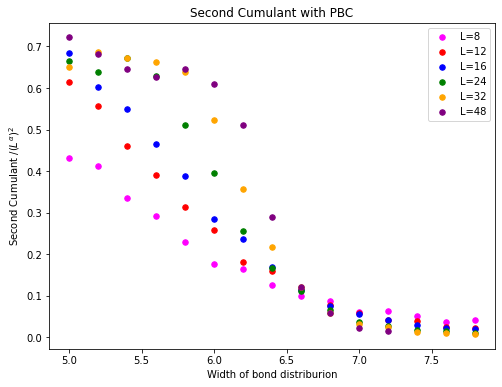

In [126]:
plt.figure(figsize=(8, 6))
for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], np.array(second_cum_comp[i])/L**2, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], np.array(fourth_cum_comp[i])/L**8, c=c_dict[L], marker='s', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], 1 - np.array(fourth_cum_comp[i])/np.array(second_cum_comp[i])**2/3, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], np.array(order_param_comp[i])/L**3, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    
plt.ylabel(r"Second Cumulant /$(L^\alpha)^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Second Cumulant with PBC")
#plt.xlim(4.5, 5.5)
#plt.ylim(0, 0.1)
plt.legend()
#plt.savefig("PBC_scaled_second_cumulant")

In [42]:
plt.figure(figsize=(8, 6))
for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], np.array(second_cum_comp[i])/L**4, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], np.array(fourth_cum_comp[i])/L**8, c=c_dict[L], marker='s', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], 2 - np.array(fourth_cum_comp[i])/np.array(second_cum_comp[i])**2/3, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    
plt.ylabel(r"Second Cumulant /$(L^\alpha)^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Second Cumulant of Maximum cluster size")
#plt.xlim(4.5, 5.5)
#plt.ylim(0, 0.1)
plt.legend()
#plt.savefig("PBC_scaled_second_cumulant")

1.17

In [158]:
L_list = [10, 20, 40, 80]
c_dict = {10: 'magenta', 20:'red', 40:'blue', 80:'green', 32:'orange', 48:'purple'}



w_vals_comp = []
lcs_comp = []
mag_err_comp = []
magnetization_comp = []
marker_comp = []

for L in L_list:
    log_file = pd.read_csv(run_dir+"log_file.csv")
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    n_runs_list = fixed_length_slice['n_runs'].tolist()
    #misc_notes = fixed_length_slice['misc'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    largest_clust_size = []
    #largest_clust_size_err = []
    magnetization = []
    mag_err = []
    
    w_list = []
    c_list = []
    m_list = []
    

    for index, ts in enumerate(ts_list):
        
        #if str(30) in misc_notes[index]: continue#m_type, c_type = 'o', 'red'
        #elif "no" in misc_notes[index]: m_type, c_type = 'x', 'blue'
        #m_list.append(m_type)
        
        with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list, mag_list = [], [], []

        for core_pair in clust_list_final:
            clust_list_temp  = core_pair[0] 
            reverse_list_temp = core_pair[1]
            mag_temp = core_pair[-1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
            mag_list+=mag_temp

        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        largest_clust_size.append(largest_clust_list.mean()/L**2)
        magnetization.append(np.array(mag_list).mean()/L**2)
        mag_err.append(np.array(mag_list).std()/L**2/np.sqrt(n_runs_list[index]))
        w_list.append(w_vals[index])
        #c_list.append(c_dict[L])
    
    w_vals_comp.append(w_list)
    lcs_comp.append(largest_clust_size)
    magnetization_comp.append(magnetization)
    mag_err_comp.append(mag_err)
    #marker_comp.append(m_list)
    

(0.0, 0.2)

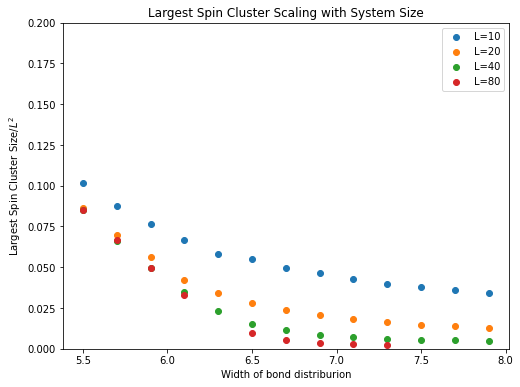

In [160]:
plt.figure(figsize=(8, 6))

for i, L in enumerate(L_list):
    #for ind, w in enumerate(w_vals_comp[i]):
    #    plt.scatter(w, lcs_comp[i][ind], c=c_dict[L], marker=marker_comp[i][ind])
    plt.scatter(w_vals_comp[i], lcs_comp[i], label='L='+str(L))
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster Scaling with System Size")
plt.legend()
#plt.yscale('log')
plt.ylim(0, 0.2)

Text(0, 0.5, 'Magnetization ratio m(2L)/m(L)')

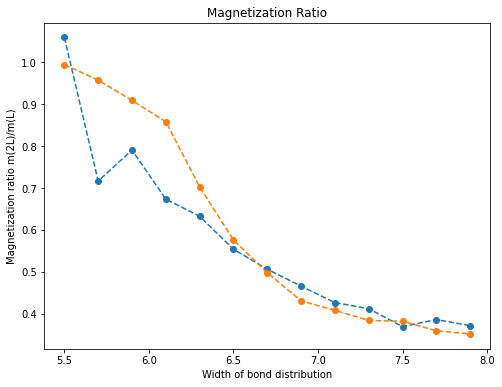

In [134]:
plt.figure(figsize=(8, 6))

plt.plot(w_vals_comp[1], np.array(magnetization_comp[1])/np.array(magnetization_comp[0]),marker='o', linestyle='--')
plt.plot(w_vals_comp[2], np.array(magnetization_comp[2])/np.array(magnetization_comp[1]), marker='o', linestyle='--')
#plt.plot(w_vals_comp[4], np.array(magnetization_comp[4])/np.array(magnetization_comp[2][:-13]), label="m(32)/m(16)", marker='o', linestyle='--')
#plt.plot(w_vals_comp[0][:-3], np.array(magnetization_comp[5])/np.array(magnetization_comp[3][:-3]), label="m(48)/m(24)", marker='o', linestyle='--')

plt.title("Magnetization Ratio")
plt.xlabel("Width of bond distribution")
plt.ylabel("Magnetization ratio m(2L)/m(L)")
#plt.savefig("mag_scaling")

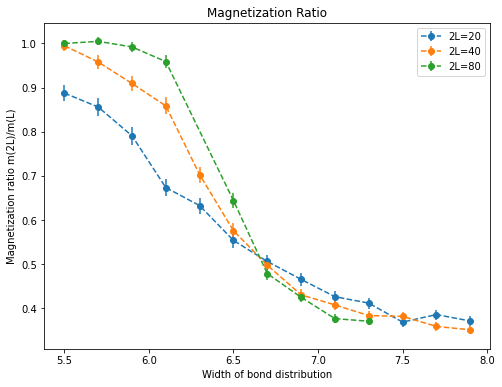

In [161]:
plt.figure(figsize=(8, 6))

for i in [1,2,3]:
    w_vals = []
    mag_ratio = []
    mag_ratio_err = []
    for index, w_val in enumerate(w_vals_comp[i]):
        ind2 = np.where(np.array(w_vals_comp[i-1])==w_val)[0][0]
        
        num = magnetization_comp[i][index]
        denom = magnetization_comp[i-1][ind2]
        
        num_err = mag_err_comp[i][index]
        denom_err = mag_err_comp[i-1][ind2]
        
        y_dat = num/denom
        y_err = y_dat * np.sqrt((num_err/num)**2+(denom_err/denom)**2)
        
        w_vals.append(w_val)
        mag_ratio.append(y_dat)
        mag_ratio_err.append(y_err)
    #print(w_vals, mag_ratio, mag_ratio_err)
    plt.errorbar(w_vals, mag_ratio, yerr=mag_ratio_err, marker='o', linestyle='--', label="2L="+str(L_list[i]))
    
plt.title("Magnetization Ratio")
plt.xlabel("Width of bond distribution")
plt.ylabel("Magnetization ratio m(2L)/m(L)")
plt.legend()

plt.savefig("mag_scaling_err_3")

In [142]:
w_vals_comp[0]

[5.7, 5.5, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7, 7.9]